In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## About the data set:

These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results
The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
The date in yyyy-mm-dd format
The local time of day in hh:mm:ss 24-hour format
The numeric data, if any (may be an empty string)
The text data, if any (may be an empty string)

The units of each dataset are:

--Solar radiation: watts per meter^2

--Temperature: degrees Fahrenheit

--Humidity: percent

--Barometric pressure: Hg

--Wind direction: degrees

--Wind speed: miles per hour

--Sunrise/sunset: Hawaii time

# Explore the data to gain insights

In [262]:
#Loading the data into a pandas data frame

Data = pd.read_csv("SolarPrediction.csv")
Data = Data.sort_values(['UNIXTime'], ascending = [True])
Data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7416,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
7415,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
7414,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
7413,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
7412,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


Note that the 'Temperature' column is in degrees Fahrenheit. We decided to transform it in Celsius

In [263]:
def celsius(F):
    '''Convert Fahrenheit into Celsius'''
    return (F-32)/1.8

Temp_c = [round(celsius(F),0) for F in Data['Temperature'].values] #List of Celsius Values

In [264]:
#Changing the values in the dataframe
for index,celsius in enumerate(Temp_c):
    Data['Temperature'].values[index] = celsius   

We also want to add a 'month' column in order to group our data and make month predictions

In [265]:
# I decide to use numerical values for the month column and convert to string when plotting... (memory :) ) 

num_month = []

for month in Data["Data"].values:  #Take a look in how the objct is given in the "Data" column
    if int(month[0]) == 9:   # In month 9 we want the first index
        num_month.append(9)
    if int(month[0]) == 1: # In months 10,11,12 we want the first 2 index
        num_month.append(int(month[:2]))

In [266]:
# I decide to use numerical values for the month column and convert to string when plotting... (memory :) ) 

num_month_df = pd.DataFrame({'Month': num_month}) # Creating a dataframe 
   
Data = Data.join(num_month_df) # Merging both data frames  

In [267]:
# Now we check our changes:

Data.head() # Note that we added a month column and we converted the temperature to celsius

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month
7416,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,11,30.43,103,77.27,11.25,06:07:00,18:38:00,9
7415,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,11,30.43,103,153.44,9.00,06:07:00,18:38:00,9
7414,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,11,30.43,103,142.04,7.87,06:07:00,18:38:00,9
7413,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,11,30.43,103,144.12,18.00,06:07:00,18:38:00,9
7412,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,11,30.43,103,67.42,11.25,06:07:00,18:38:00,9


In [268]:
#Checking the data-type of the columns and if we have missing entries

Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32686 entries, 7416 to 24522
Data columns (total 12 columns):
UNIXTime                  32686 non-null int64
Data                      32686 non-null object
Time                      32686 non-null object
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
TimeSunRise               32686 non-null object
TimeSunSet                32686 non-null object
Month                     32686 non-null int64
dtypes: float64(4), int64(4), object(4)
memory usage: 4.5+ MB


The most precise approach would be to make a model based on the given dava of time, date, unixtime, etc... But as we know, the others attributes are dependents of those (e.g. temp has a dependence on season), so to simplify our analysis we will just drop those attributes and try to find key features to create our model


So all the 'object' columns is not important neither is 'UNIXTime', let's drop them

*** Probably is a good idea to make an future analysis also based on time, maybe reasulting in a richer model or at least a richer visualization *** 

In [269]:
Data = Data.drop([
    'UNIXTime',
    'Data',
    'Time',
    'TimeSunRise',
    'TimeSunSet'],
    axis = 1) 

In [270]:
#Using the describe() method to gain some fast insights about the data

Data.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,10.600196,30.422879,75.016307,143.489821,6.243869,10.526066
std,315.916387,3.471827,0.054673,25.990219,83.167500,3.490474,1.096691
min,1.110000,1.000000,30.190000,8.000000,0.090000,0.000000,9.000000
25%,1.230000,8.000000,30.400000,56.000000,82.227500,3.370000,10.000000
50%,2.660000,10.000000,30.430000,85.000000,147.700000,5.620000,11.000000
75%,354.235000,13.000000,30.460000,97.000000,179.310000,7.870000,11.000000
max,1601.260000,22.000000,30.560000,103.000000,359.950000,40.500000,12.000000


The first thing we have to have in mind is what we wanna do. Our goal in that project is to predict the level of solar radiation.

We can see that all entries are 'non-null' wich will make our work easier.

We can also see that the standard deviation of 'Pressure' is pretty low and the standard deviation of 'Radiation' is the greater of all features. So, if Pressure is almost constant while Radiation has a high standard deviation, we can assume that pressure is not an important feature to our goal.

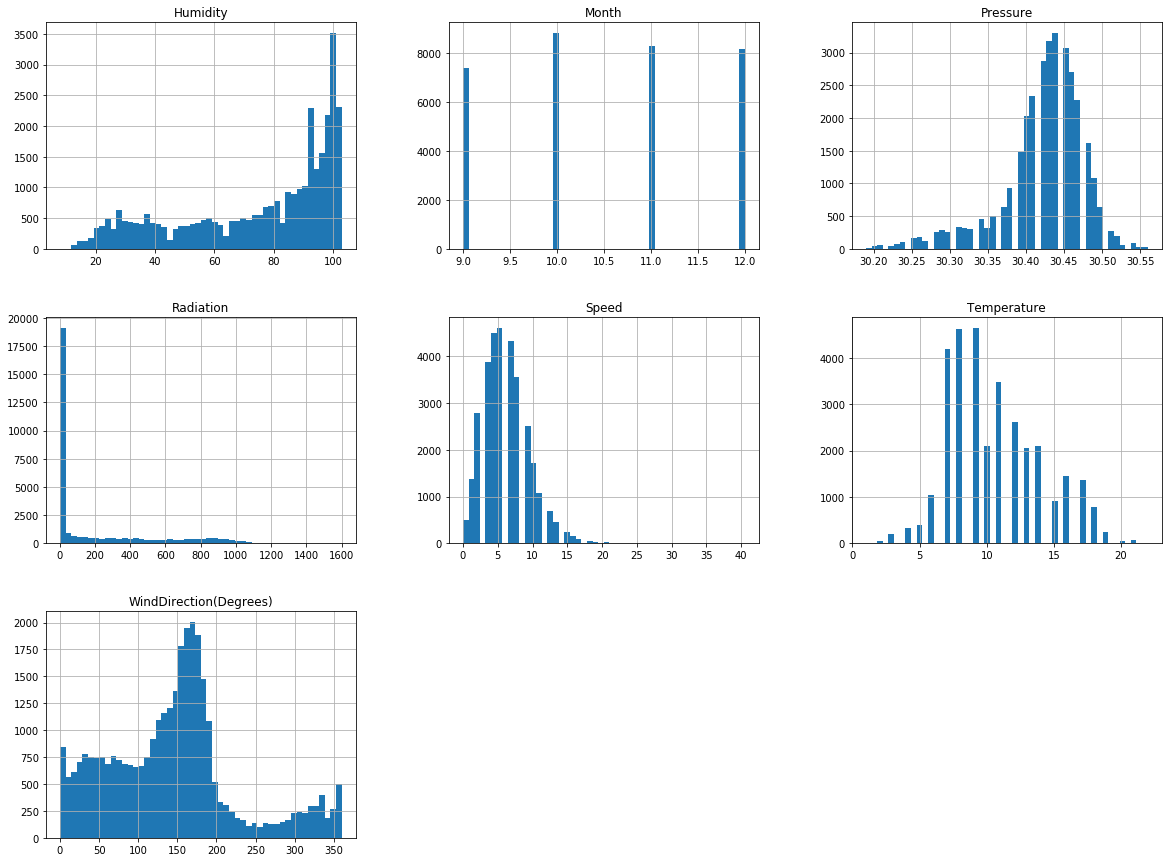

In [271]:
#Plotting a histogram of each numerical feature in order to gain more insights

Data.hist(bins=50, figsize=(20,15))
plt.show()

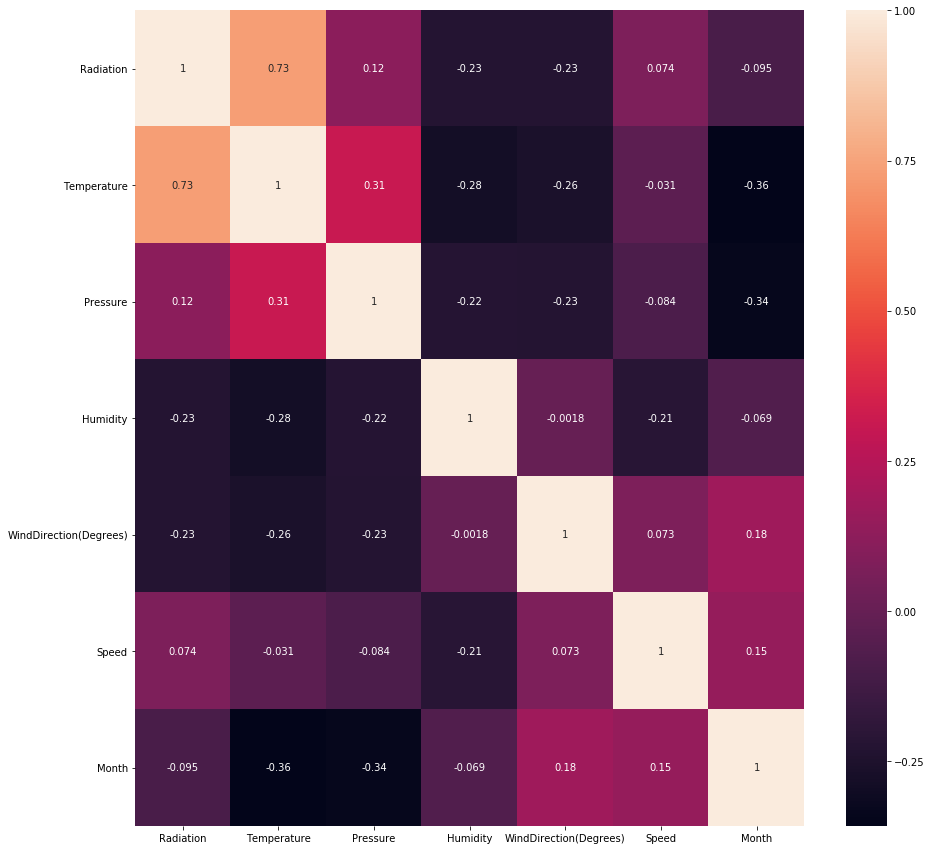

In [272]:
#Creating a correlation heatmap using seaborn

cor = Data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True)

With that correlation heatmap it's easier to see wich feature is most important for the model we want to create.

As you can see the highest correlation (magnitude) with Radiation is 'Temperature' (pos. correlated, 0.73), followed by 'Humidity' and 'WindDirection' (both neg. correlated, -0.23)

Let's plot those attributes

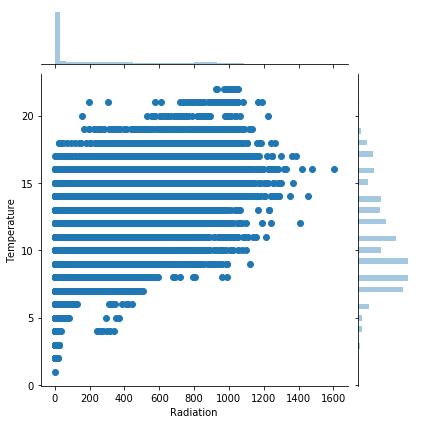

In [273]:
sns.jointplot(x="Radiation", y="Temperature", data=Data)

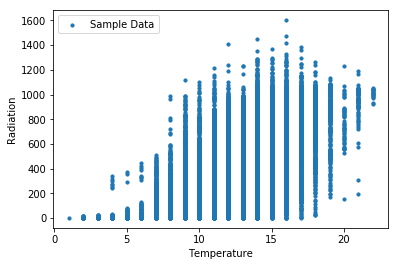

In [274]:
plt.scatter(Data['Temperature'].values, Data['Radiation'].values, label='Sample Data', s=10)
plt.xlabel('Temperature')
plt.ylabel('Radiation')
plt.legend()
plt.show()

# Creating a test set    (testando, jaja comento) 

In [275]:
# As seen in the correlation heatmap the Temperature is a key feature

Data["Temp"] = pd.cut(Data["Temperature"],  
                               bins=[0.,5,10,15,20, np.inf],
                               labels=[1,2,3,4,5])   # Creating strata

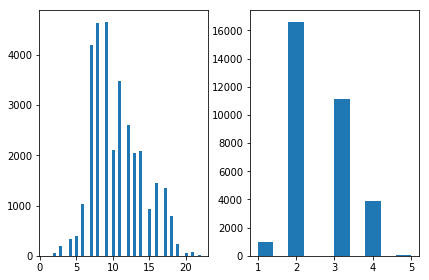

In [276]:
figs, axes = plt.subplots(1,2) # Check if divisions were well chosen 
plt.tight_layout() 

axes[0].hist(Data["Temperature"], bins = 50) 
axes[1].hist(Data["Temp"])

plt.show()

In [277]:
#Using the stratifiedshufflesplit 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(Data, Data['Temp']):
    strat_train_set = Data.loc[train_index]
    strat_test_set = Data.loc[test_index] 

In [278]:
strat_train_set['Temp'].value_counts() / len(strat_train_set['Temp']) # Check proportions 

2    0.508834
3    0.340370
4    0.118173
1    0.029830
5    0.002792
Name: Temp, dtype: float64

In [279]:
Data['Temp'].value_counts() / len(Data['Temp']) # Representativity is maintained 

2    0.507649
3    0.341002
4    0.118828
1    0.029799
5    0.002723
Name: Temp, dtype: float64

In [280]:
for set_ in (strat_train_set, strat_test_set):  # Remove strata 
    set_.drop("Temp", axis=1, inplace=True)

In [290]:
df_strat = strat_train_set.copy() # Don't want to mess with the original train set

In [291]:
df_strat_ts = df_strat.drop('Radiation', axis=1) # Remove target feature

In [295]:
df_labels = df_strat['Radiation'].copy() # Get labels for training

# Making some plots (jaja comento melhor)

Now we wanna see the mean Temperature of each month

In [283]:
# Using the pandas method "groupby" we can groupy our features in respect to the column "Month"

df_strat.groupby(['Month']).mean()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
Month,,,,,
9,12.065056,30.432007,79.512673,134.946773,5.446916
10,11.347042,30.438454,78.773099,126.483914,5.890439
11,10.431639,30.445855,62.457502,134.845404,6.851295
12,8.606628,30.374475,79.373581,177.916623,6.762705


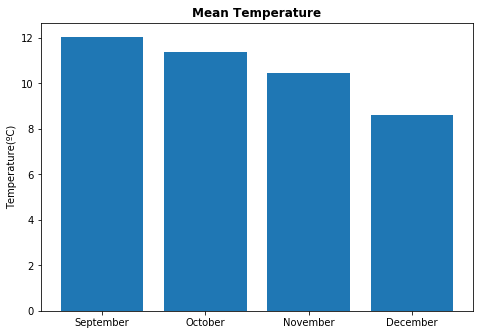

In [284]:
#Creating a bar plot of the mean temperature(Celsius) of a given month

mean_temperature_month = Data.groupby(['Month']).mean()["Temperature"].values #array with the mean temperature of each month

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
str_months = ["September", "October", "November", "December"]
ax.bar(str_months,mean_temperature_month)
plt.ylabel("Temperature(ºC)")
plt.title("Mean Temperature",fontweight="bold")


#We can stylize it better, taking a break now... 

plt.show()

# Preprocessing the data

## Feature Scaling
It is important to standarize the scaling of different features so that the algorithms can better evaulate their importance. For that, we construct a transformation pipeline.

In [285]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [301]:
pipeline = Pipeline([
    ('std_scaler',StandardScaler())
])

transf_df_strat_ts = pipeline.fit_transform(df_strat_ts)
transf_df_labels = pipeline.fit_transform(np.array([df_labels]).reshape(-1, 1))

C:\Users\Computador\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Computador\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [311]:
transf_df_labels = np.ravel(transf_df_labels) # Convert from column vector to 1d array (for using in Randomized Search CV)

array([-0.65215872, -0.65206356, -0.652127  , ...,  1.41807412,
       -0.65209528, -0.6043258 ])

# Selecting a model

In [330]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

Better to rewrite this code using GridSearchCV... RandomizedSearch as it is was pointless.

In [331]:
rnd_forest_reg = RandomForestRegressor()  # Using RandomizedSearchCV with a RandomForestRegressor wasn't worth it

params = {
    'n_estimators': list(range(1,100,5)), # Couldn't use a probability distribution since 'n_estimators' must be integer
    'bootstrap':[True, False],  # I used it as if it were GridSearchCV... maybe we figure a way to change this.
    'max_features':[2,3,4,5,6]
}

random_search = RandomizedSearchCV(rnd_forest_reg, param_distributions = params,
                                  n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                  verbose = 2, random_state=42)

random_search.fit(transf_df_strat_ts, transf_df_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=76, max_features=6, bootstrap=True .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. n_estimators=76, max_features=6, bootstrap=True, total=   4.1s
[CV] n_estimators=76, max_features=6, bootstrap=True .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] .. n_estimators=76, max_features=6, bootstrap=True, total=   4.4s
[CV] n_estimators=76, max_features=6, bootstrap=True .................
[CV] .. n_estimators=76, max_features=6, bootstrap=True, total=   4.1s
[CV] n_estimators=76, max_features=6, bootstrap=True .................
[CV] .. n_estimators=76, max_features=6, bootstrap=True, total=   4.3s
[CV] n_estimators=76, max_features=6, bootstrap=True .................
[CV] .. n_estimators=76, max_features=6, bootstrap=True, total=   4.3s
[CV] n_estimators=76, max_features=2, bootstrap=True .................
[CV] .. n_estimators=76, max_features=2, bootstrap=True, total=   1.9s
[CV] n_estimators=76, max_features=2, bootstrap=True .................
[CV] .. n_estimators=76, max_features=2, bootstrap=True, total=   1.8s
[CV] n_estimators=76, max_features=2, bootstrap=True .................
[CV] .. n_estimators=76, max_features=2, bootstrap=True, total=   1.8s
[CV] n_estimators=76, max_features=2, bootstrap=True .................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96], 'bootstrap': [True, False], 'max_features': [2, 3, 4, 5, 6]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [332]:
negative_mse = random_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

0.4585344134279407

In [333]:
random_search.best_params_

{'n_estimators': 76, 'max_features': 2, 'bootstrap': False}

In [334]:
best_est = random_search.best_estimator_
features = df_strat_ts.columns

for feat, importance in zip(features, best_est.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: Temperature, importance: 0.4711639211729462
feature: Pressure, importance: 0.06945855640744168
feature: Humidity, importance: 0.1412230287815893
feature: WindDirection(Degrees), importance: 0.2214060045963652
feature: Speed, importance: 0.055330602912869196
feature: Month, importance: 0.04141788612878843


Weird... WindDirection is deemed as the second most important feature. However, it is not clear how to make sense of this physically. 

# Running model into test set

In [335]:
final_model = random_search.best_estimator_

In [336]:
test_df_strat = strat_test_set.drop("Radiation", axis=1)
test_labels = strat_test_set["Radiation"].copy()

In [338]:
test_df_strat_standarized = pipeline.transform(test_df_strat)

C:\Users\Computador\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [339]:
final_predictions = final_model.predict(test_df_strat_standarized)

In [340]:
final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)

In [341]:
final_rmse   

380.9144780985215

### WAY BIGGER than what was achieved in the cross validation. This means the model is heavily overfit.

f's in the chat boys